In [1]:
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet, set_log_level

In [2]:
data = pd.read_csv('./Data/Beijing.csv')

In [3]:
import datetime
data['time'] = [datetime.datetime(data.iloc[i,0],data.iloc[i,1],data.iloc[i,2],data.iloc[i,3]) for i in range(len(data))]

In [4]:
data.set_index('time',inplace=True)


根据观察，首先我们要禁用`weekly_seasonality`,即应该不遵循一周的周期序列，同时我们要增加`n_changepoints`和增加`changepoints_range`，因为我们正在进行短期预测。此外，我们可以利用明天的天气很可能与昨天的天气相似的事实。这意味着我们将根据最近的过去值回归我们的时间序列，也称为自回归。
通过设置n_lags期望的过去观察次数来回归来实现这一点。

In [79]:
m = NeuralProphet(
    n_lags=4*6*3,
    n_forecasts=1,
    n_changepoints=0,
    weekly_seasonality=False,
    daily_seasonality=False,
    learning_rate=0.01,
    num_hidden_layers=4,
    d_hidden=8,
    ar_reg=0.1,
)


In [6]:
temp = pd.DataFrame(data['NO2']).reset_index()
temp.columns = ['ds','y']

In [7]:
temp

,ds,y
0,2014-01-01 00:00:00,73.0
1,2014-01-01 01:00:00,84.0
2,2014-01-01 02:00:00,85.0
3,2014-01-01 03:00:00,83.0
4,2014-01-01 04:00:00,83.0
...,...,...
17515,2015-12-31 19:00:00,114.0
17516,2015-12-31 20:00:00,118.0
17517,2015-12-31 21:00:00,125.0
17518,2015-12-31 22:00:00,130.0


In [78]:
train_size = 0.9*int(len(temp)/4)

In [80]:
df_train, df_test = m.split_df(df=temp, freq="4H", valid_p=0.1)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.994% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency 4H is different than major frequency H
INFO - (NP.forecaster.__handle_missing_data) - 122 NaN values in column y were auto-imputed.


In [81]:
metrics = m.fit(df_train, freq='4H')

INFO - (NP.df_utils._infer_frequency) - Major frequency 4H corresponds to 99.975% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 4H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 131
Epoch[131/131]: 100%|██████████| 131/131 [00:13<00:00,  9.89it/s, SmoothL1Loss=0.0138, MAE=15.5, RMSE=20.5, RegLoss=0.00375] 


In [82]:
forecast = m.predict(temp)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.994% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency 4H is different than major frequency H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency 4H is different than major frequency H
INFO - (NP.forecaster.__handle_missing_data) - 122 NaN values in column y were auto-imputed.


In [44]:
forecast

,ds,y,yhat1,residual1,ar1,trend
0,2014-01-01 00:00:00,73.0,None,NaN,None,None
1,2014-01-01 04:00:00,83.0,None,NaN,None,None
2,2014-01-01 08:00:00,84.0,None,NaN,None,None
3,2014-01-01 12:00:00,16.0,None,NaN,None,None
4,2014-01-01 16:00:00,21.0,None,NaN,None,None
...,...,...,...,...,...,...
4375,2015-12-31 04:00:00,66.0,80.763931,14.763931,53.255707,27.508223
4376,2015-12-31 08:00:00,71.0,60.729275,-10.270725,33.220753,27.508522
4377,2015-12-31 12:00:00,50.0,65.2715,15.2715,37.762676,27.508823
4378,2015-12-31 16:00:00,92.0,60.900017,-31.099983,33.390892,27.509123


In [54]:
m = m.highlight_nth_step_ahead_of_each_forecast(1)


In [66]:
forecast

,ds,y,yhat1,residual1,ar1,trend
0,2014-01-01 00:00:00,73.0,None,NaN,None,None
1,2014-01-01 04:00:00,83.0,None,NaN,None,None
2,2014-01-01 08:00:00,84.0,None,NaN,None,None
3,2014-01-01 12:00:00,16.0,None,NaN,None,None
4,2014-01-01 16:00:00,21.0,None,NaN,None,None
...,...,...,...,...,...,...
4375,2015-12-31 04:00:00,66.0,66.224167,0.224167,78.835518,-12.611352
4376,2015-12-31 08:00:00,71.0,76.402481,5.402481,89.014458,-12.611979
4377,2015-12-31 12:00:00,50.0,76.491013,26.491013,89.103615,-12.612607
4378,2015-12-31 16:00:00,92.0,34.304977,-57.695023,46.918217,-12.613235


In [15]:
import matplotlib.pyplot as plt

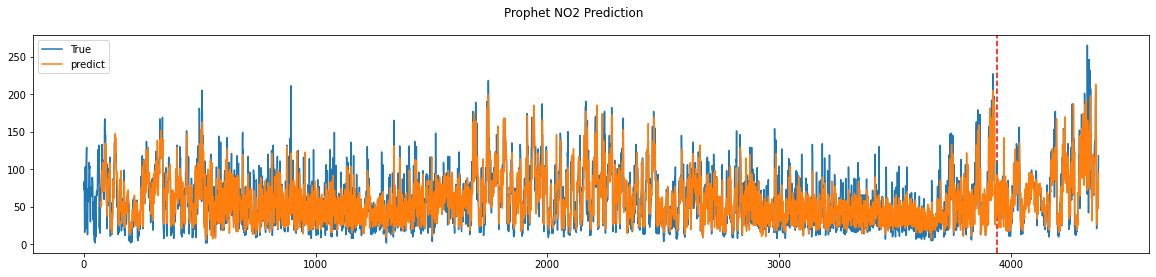

In [83]:
plt.figure(figsize=(20, 4))
plt.axvline(x=train_size, c='r', linestyle='--')
plt.plot(forecast['y'],label = 'True')
plt.plot(forecast['yhat1'],label = 'predict')
plt.legend()
plt.suptitle('Prophet NO2 Prediction')
plt.savefig('./figure/NO2_Predict_Prophet_0.9.png')

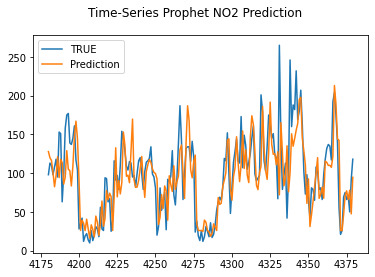

In [84]:
plt.plot(forecast['y'][-200:],label='TRUE')
plt.plot(forecast['yhat1'][-200:],label='Prediction')
plt.legend()
plt.suptitle('Time-Series Prophet NO2 Prediction')
plt.savefig('./figure/NO2_Predict_Prophet_0.9_2.png')

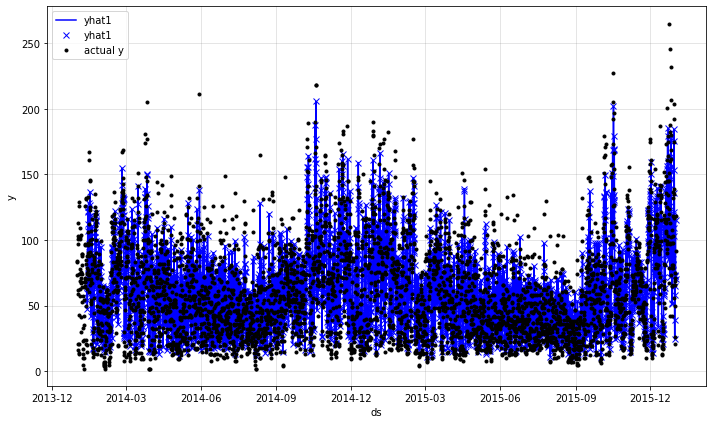

In [12]:
fig = m.plot(forecast)


In [85]:
m.test(temp)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.994% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency 4H is different than major frequency H
INFO - (NP.forecaster.__handle_missing_data) - 122 NaN values in column y were auto-imputed.
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.015 15.863 21.379


,SmoothL1Loss,MAE,RMSE
0,0.014814,15.863158,21.379117


In [82]:
m.make_future_dataframe(temp,periods=1)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.994% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency 4H is different than major frequency H


,ds,y
0,2015-12-29 00:00:00,252.0
1,2015-12-29 01:00:00,267.0
2,2015-12-29 02:00:00,289.0
3,2015-12-29 03:00:00,301.0
4,2015-12-29 04:00:00,312.0
...,...,...
68,2015-12-31 20:00:00,122.0
69,2015-12-31 21:00:00,149.0
70,2015-12-31 22:00:00,196.0
71,2015-12-31 23:00:00,221.0


In [83]:
m.predict(m.make_future_dataframe(temp,periods=1,n_historic_predictions=len(temp))).tail(20)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.994% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency 4H is different than major frequency H
WARNING - (NP.forecaster._make_future_dataframe) - Insufficient data for 17520 historic forecasts, reduced to 17448.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency 4H is different than major frequency H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency 4H is different than major frequency H
INFO - (NP.forecaster.__handle_missing_data) - 113 NaN values in column y were auto-imputed.


,ds,y,yhat1,residual1,ar1,trend
4361,2015-12-28 20:00:00,149.0,122.661667,-26.338333,64.959229,57.702435
4362,2015-12-29 00:00:00,252.0,243.301819,-8.698181,185.599701,57.702122
4363,2015-12-29 04:00:00,312.0,344.114929,32.114929,286.413116,57.701809
4364,2015-12-29 08:00:00,263.0,289.566864,26.566864,231.865372,57.7015
4365,2015-12-29 12:00:00,180.0,153.413971,-26.586029,95.712769,57.701191
4366,2015-12-29 16:00:00,323.0,261.809418,-61.190582,204.108551,57.700882
4367,2015-12-29 20:00:00,507.0,436.147034,-70.852966,378.446472,57.700569
4368,2015-12-30 00:00:00,447.0,437.64209,-9.35791,379.941833,57.70026
4369,2015-12-30 04:00:00,275.0,260.458405,-14.541595,202.758438,57.699951
4370,2015-12-30 08:00:00,7.0,41.862236,34.862236,-15.837402,57.699638


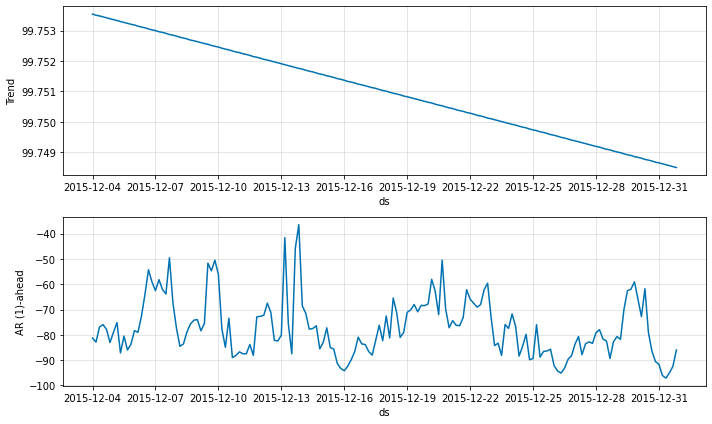

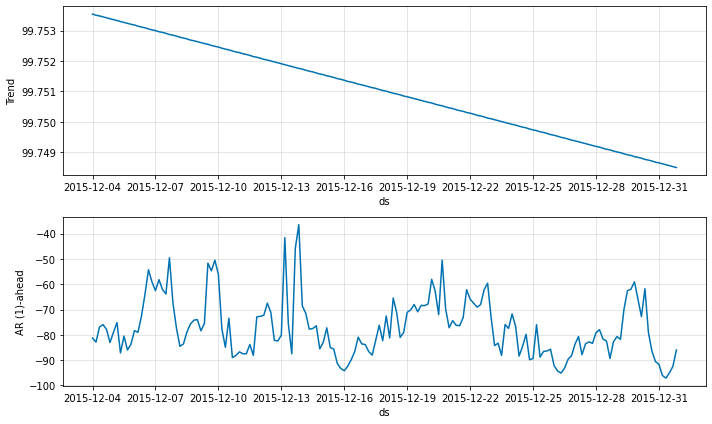

In [14]:
m.plot_components(forecast[-7*24:])

循环预测

In [10]:
data = pd.read_csv('./Data/datafull.csv',index_col=0)

In [11]:
data.drop(columns=['WD', 'WS'],inplace= True)

In [12]:
data1 = pd.read_csv('./Data/datafull.csv',index_col= 0)


In [13]:
data1.drop(columns=['WD', 'WS'],inplace= True)

In [14]:
for i in range(10):
    data1.loc[len(data1)] = 0
    data1.index= data1.index[:-2].append(pd.date_range(data1.index[-2],periods=2,freq='4H'))

In [15]:
for names in data1.columns:
    m = NeuralProphet(
    n_lags=4*6*3,
    n_forecasts=10,
    n_changepoints=0,
    weekly_seasonality=False,
    daily_seasonality=False,
    learning_rate=0.01,
    num_hidden_layers=4,
    d_hidden=8,
    ar_reg=0.1,
    )
    temp = pd.DataFrame(data[names]).reset_index()
    temp.columns = ['ds','y']
    metrics = m.fit(temp, freq='4H')
    data1[names][-10:] = m.predict(m.make_future_dataframe(temp,periods=10,n_historic_predictions=len(temp)))['yhat10'][-10:]


INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 98.649% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency 4H is different than major frequency H
INFO - (NP.forecaster.__handle_missing_data) - 183 NaN values in column y were auto-imputed.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 128
Epoch[128/128]: 100%|██████████| 128/128 [00:14<00:00,  8.66it/s, SmoothL1Loss=0.0284, MAE=46.1, RMSE=65, RegLoss=0.000629]  
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 98.649% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency 4H is different than major frequency H
WARNING

In [16]:
data1

,PM2.5,PM10,SO2,NO2,O3,CO,TEMP,PRES,RAIN,HUMI,DEWP,EWS,NWS
2014-01-01 01:00:00,58.0,154.0,39.0,84.0,4.0,1.5,-1.1,1008.8,0.0,40.0,-13.0,-0.848528,-0.848528
2014-01-01 02:00:00,68.0,162.0,39.0,85.0,4.0,1.7,-1.4,1008.8,0.0,41.0,-13.0,-0.494975,-0.494975
2014-01-01 03:00:00,83.0,189.0,63.0,83.0,5.0,1.7,-2.4,1008.2,0.0,46.0,-12.5,0.424264,0.424264
2014-01-01 04:00:00,75.0,190.0,55.0,83.0,3.0,2.1,-2.5,1008.0,0.0,46.0,-12.6,0.0,0.0
2014-01-01 05:00:00,83.0,189.0,49.0,84.0,6.0,2.4,-2.1,1008.3,0.0,45.0,-12.5,0.353553,0.353553
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-01-01 23:00:00,78.647606,119.747704,17.423985,89.938187,20.504555,1.268756,0.039758,1025.687134,0.077889,62.258827,-9.508249,-0.153085,0.062768
2016-01-02 03:00:00,75.927635,87.177818,15.078616,94.480179,17.809216,2.15399,-3.086268,1025.442993,0.077897,76.424461,-9.239042,-0.153099,0.090998
2016-01-02 07:00:00,61.882511,81.848381,10.624178,83.396118,16.393505,3.250348,-3.138051,1024.928467,0.077906,68.667221,-8.999342,-0.153112,0.084952
2016-01-02 11:00:00,58.796082,87.503944,15.386889,75.723289,24.524502,3.852434,-1.883319,1024.507812,0.077914,61.448841,-8.798462,-0.153126,0.090982


In [17]:
data1.to_csv('./Data/neural_prophet.csv')

In [86]:
data2 = pd.read_csv('./Data/neural_prophet.csv',index_col=0)

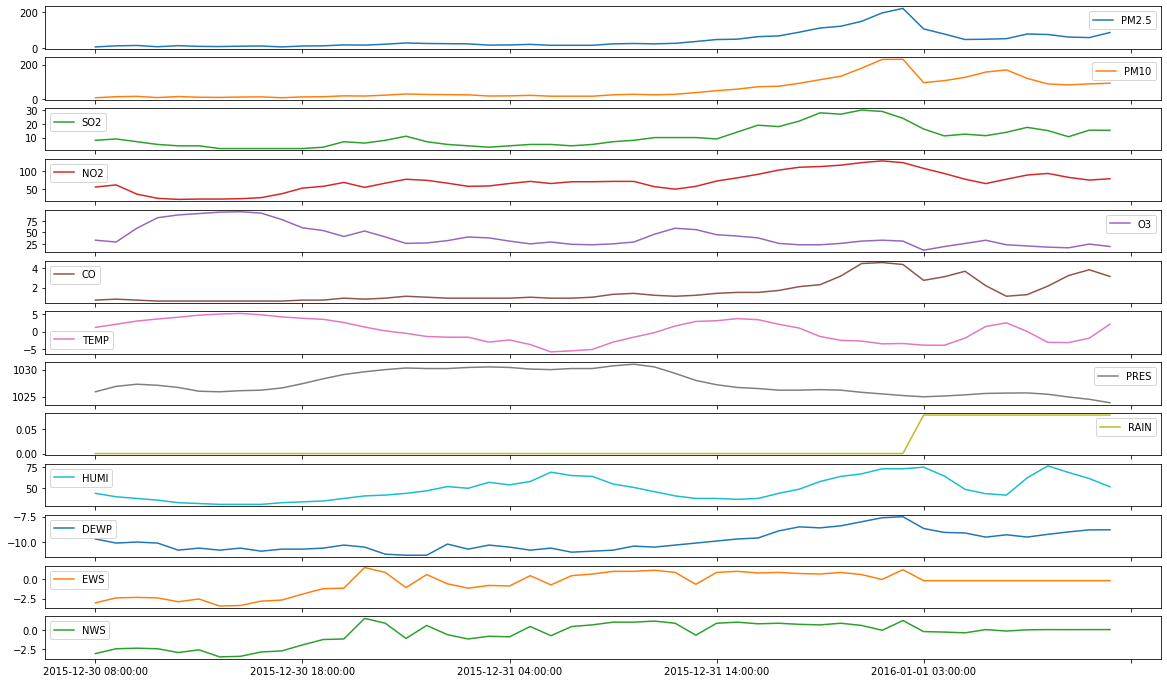

In [88]:
data2[-50:].plot(subplots = True,figsize = (20,12))
plt.savefig('./figure/Predict_Prophet.png')